In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Описание задачи

В нашей модели есть типы Агентов:
*   Мороженщики j = 1, ..., n (n=2)
*   Покупатели i = 1, ..., m (m=const)
Также у нас есть периоды t=1, ..., T

У каждого агента есть какое-то состояние:


1.   Мороженщик: x_j, p_j, c_j
2.   Покупатель: x_i, v_i, tau_i(L)

где x - координата, p - цена товара, c - издержки, v - максимальная цена, которую готов оплатить покупатель, tau - траты на путь

## Инициализация (задаём начальные условия)

p_1 = p_2 = p = const = 1

c_1 = c_2 = c = const = 0

Мороженщики: x1 = 0, x2 = 1

Покупатели: x_i ~ U[0:1]; v_i = v = const = 3; tau_i = tau = 0,5 * L. Если хочется, то можем распределить покупателей иначе x_i ~ B_(a, b)

--

## События в течении периода t

- Покупатели выбирают что делать и идут покупать мороженное (1)
- Мороженщики считают прибыль
- Мороженщики выбирают новые x_i

Для (1):
- v_i = p_1 - tau * L_i1

- v_i = p_2 - tau * L_i2

- 0

Для (2):
- pi_j = (p_j-c_j)*q_j), q_j - кол-во потребителей у мороженщика
- сдвиг на delta, если pi_j < pi_k, j!=k



In [2]:
m = 100 # кол-во покупателей
w = 2 # кол-во продаванов
x1 = 0
x2 = 1
p = p1 = p2 = 1
c = c1 = c2 = 0
tau = 0.5
delta = 0.01
v = 3
T = 1000

In [3]:
class Person:
  def __init__(self, position):
    """
    Конструктор класса Person.

    Args:
    x (float): Позиция на рынке.
    """
    self.x = position

class Seller(Person):
  _counter = 0

  def __init__(self, position, price, costs, delta):
    """
    Конструктор класса Seller.

    Args:
    position (float): Позиция на рынке.
    price (float): Цена продажи.
    costs (float): Издержки производства.
    delta (float): Шаг перемещения.
    """
    super().__init__(position)
    self.n = Seller._counter
    Seller._counter += 1
    self.price = price
    self.costs = costs
    self.quantity = 0
    self.profit = 0
    self.delta = delta
    self.new_x =self.x

  def calc_profit(self):
    """
    Рассчитывает прибыль продавца.
    """
    self.profit = (self.price - self.costs) * self.quantity

  def start_period(self):
    """
    Сбрасывает количество продаж и прибыль продавца.
    """
    self.quantity = 0
    self.profit = 0
    self.x = self.new_x

  def move(self, others):
    """
    Перемещает продавца на рынке.

    Args:
    others (list): Список других участников рынка.
    """
    max_profit_seller = max(others, key = lambda seller: seller.profit)
    self.new_x = self.x - delta * np.sign(self.x - max_profit_seller.x)

class Customer(Person):
  def __init__(self, position = np.random.uniform(), v = 3, tau = 0.5):
    """
    Конструктор класса Customer.

    Args:
    v (float): Величина стоимости товара для покупателя.
    tau (float): Величина, характеризующая чувствительность покупателя к расстоянию до продавца.
    """
    super().__init__(position)
    self.v = v
    self.tau = tau

  def choose(self, sellers_arr):
    """
    Выбирает продавца для совершения покупки.

    Args:
    sellers_arr (list): Список доступных продавцов.

    Returns:
    Seller: Продавец, выбранный покупателем.
    """
    u_values = [self.v - seller.price - self.tau * abs(self.x - seller.x) for seller in sellers_arr]
    max_index = u_values.index(max(u_values))
    sellers_arr[max_index].quantity += 1

In [4]:
# Если надо торговцев поставить по углам, то меняем np.random.uniform() на j - 1
sellers_arr = [Seller(np.random.uniform(), p, c, delta) for j in range(1, w + 1)]
customers_arr = [Customer(np.random.uniform()) for _ in range(1, m + 1)]

In [5]:
pos_array = [[] for _ in range(len(sellers_arr))]
for t in range(T):

  # Сбрасываем количество продаж и прибыль продавцов перед началом каждого периода
  for s in sellers_arr:
    s.start_period()
  # Покупатели выбирают продавцов и совершают покупки
  for cus in customers_arr:
    cus.choose(sellers_arr)

  # Рассчитываем прибыль продавцов после совершения всех продаж в текущем периоде
  for s in sellers_arr:
    s.calc_profit()

  # Сохраняем текущие позиции продавцов
  for i, seller in enumerate(sellers_arr):
    pos_array[i].append(seller.x)

  # Продавцы перемещаются в область с наибольшей доходностью
  for s in sellers_arr:
      s.move(sellers_arr)
      
  #for s in sellers_arr:
  #  print("name: ", s.n, "; profit: ", s.profit, "; coord: ", s.x)

In [8]:
cus_positions = [cus.x for cus in customers_arr]

Text(0.5, 1.0, 'Movement')

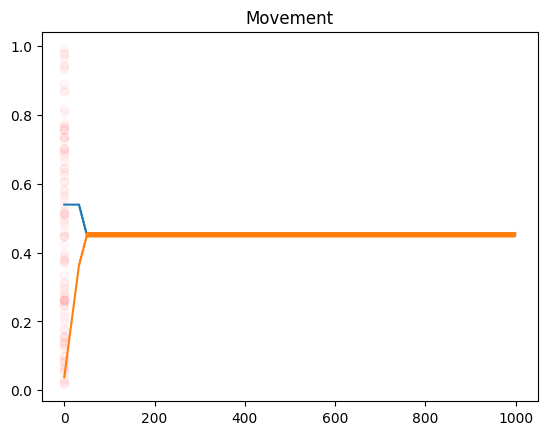

In [9]:
for i, cus_pos in enumerate(cus_positions):
    plt.scatter([0], cus_pos, c = 'red', marker='o', alpha = 0.03, label = f'Customer {i+1}')
for i, seller in enumerate(sellers_arr):
    plt.plot(pos_array[i])
plt.title("Movement")

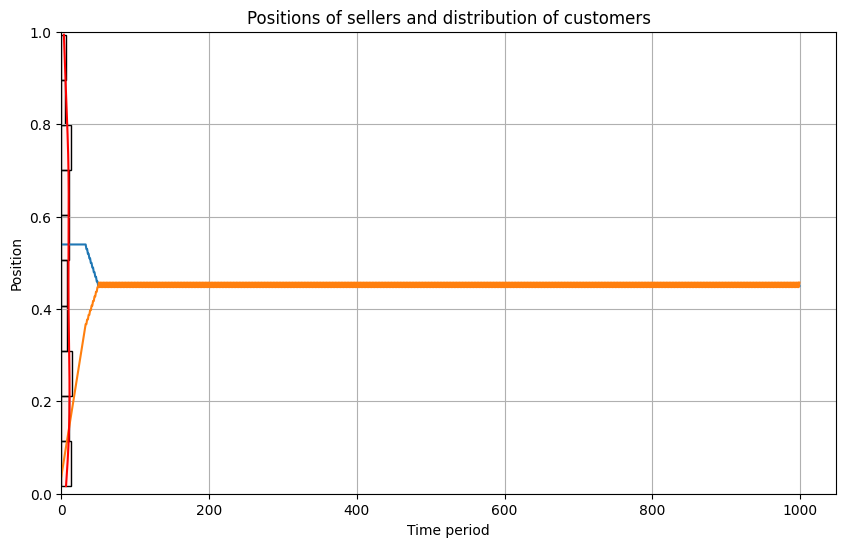

In [10]:
# Строим график
plt.figure(figsize=(10, 6))

for i, seller in enumerate(sellers_arr):
    plt.plot(pos_array[i])
# Строим гистограмму распределения позиций покупателей
sns.histplot(y = cus_positions, bins = 10, kde=True, color='red', alpha=0.05)
plt.xlabel('Time period')
plt.ylabel('Position')
plt.ylim(0, 1)
plt.title('Positions of sellers and distribution of customers')
plt.grid(True)
plt.show()